In [54]:
# this notebook will implement a two lithology - one sediment type model
# it encodes the assumption that sedimentary rocks contribute nothing to the bedload sediment flux
# (that is, all material eroded from sedimenary rocks is treated as fines)

In [55]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt

In [56]:
# SET UP GRID ARRAYS
dx = 1000
x = np.arange(0, 100000, dx)

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig = np.zeros(len(x))
beta_ig[:50] = 0.000004
beta_sed = np.zeros(len(x))
beta_sed[50:] = 0.000064

# erodibility values
k_ig = np.zeros(len(x))
k_ig[:50] = 0.0001
k_sed = np.zeros(len(x))
k_sed[50:] = 0.001

In [57]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     beta_ig,
                     beta_sed,
                     k_ig,
                     k_sed,
                     c = 1,
                     Hstar = 0.1,
                     baselevel_rate = 0.001,
                     num_steps = 500000, 
                     porosity = 0.55):
    
    H = Hstar + np.zeros(len(x))  # sediment thickness
    H[-1] = 0.0
    etab = -H
    eta = etab + H
    ero = np.zeros(len(x))  # bedrock erosion rate
    q = x  # discharge = distance downstream (first node is left edge of 0th cell)
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt = 0.2 * dx * dx / (c*q[-1])  # time-step size
    t = 0

    for i in range(num_steps):
        
        # lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        # S = 0.001
        
        # calculate e factor
        efac = np.exp(- H / Hstar)
        
        # calculate total bedload sed flux and set boundary condition
        qs[1:] = c * q[1:] * S * (1.0 - efac[:-1])
        qs[0] = 0
        
        # calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        # calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[:-1])
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[:-1])
        
        # calc bedrock erosion rate from stream power and abrasion
        ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        # calc change in bedrock elev
        etab[:-1] -= ero[:-1] * dt
        
        # calc grain attrition
        atr = beta_ig[1:] * qs[1:]
        
        # calc change in alluvial thickness
        H[:-1] += -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig)) * dt
        
        # update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
#         if t <= num_steps:
#             plt.plot(x, H)
#         else:
#             break
            
#         t += (5000 * dt)
        
    return efac, S, qs, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, ero, atr, H

In [58]:
efac, S, qs, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, ero, atr, H = two_lith_one_sed(x,
                                                                                                           dx,
                                                                                                           beta_ig,
                                                                                                           beta_sed,
                                                                                                           k_ig,
                                                                                                           k_sed)

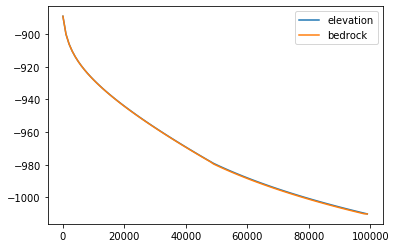

In [59]:
figsize = (10, 6)

# plt.plot(x, H, label = 'sediment')
plt.plot(x, eta, label = 'elevation')
plt.plot(x, etab, label = 'bedrock')
plt.legend()

# plt.savefig('/Users/vanessa/Desktop/FA 2021/B_ig_7_1Ga.png')

plt.show()

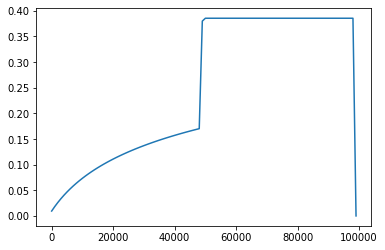

In [60]:
plt.plot(x, H)
# plt.savefig('/Users/vanessa/Desktop/FA 2021/B_ig_7_H_1Ga.png')

In [61]:
ero

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.   ])